In [5]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os

# load in directories
from experiment_code.constants import Defaults

In [36]:
# load in data from gorilla
df = pd.read_csv(os.path.join(Defaults.RAW_DIR, "gorilla_v1.csv"))


In [37]:
# filter dataframe to remove redundant cols
df_filtered = df.filter({'Experiment ID', 'Experiment Version', 'Task Version', 
           'counterbalance-mpke', 'Spreadsheet Row', 'Zone Type', 
           'Reaction Time', 'Response', 'display', 'iti_dur_ms', 
           'trial_dur_ms', 'V1', 'V2', 'V2', 'V3', 'V4', 'V5',
          'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12'})

In [38]:
# clean spreadsheet
df_filtered = df_filtered.rename({'Zone Type':'Zone_Type'}, axis=1)

In [42]:
# select response-only rows
df_filtered = df_filtered.query('Zone_Type=="response_rating_scale_likert"')

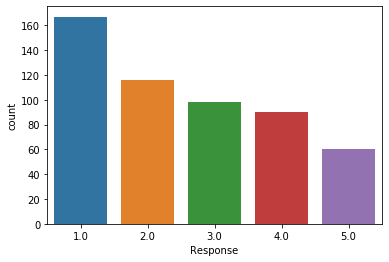

In [41]:
# Visualize distribution of responses overall
sns.countplot(x='Response', data=df_filtered);

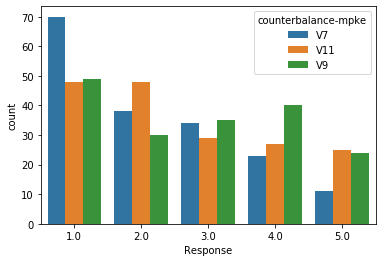

In [44]:
# Visualize distribution of responses per participant
sns.countplot(x='Response', hue='counterbalance-mpke', data=df_filtered);